In [3]:
# Internal utilities
from soln.data_loader import load

# External dependencies
import pylab as py

In [4]:
# Notebook-local utilities (ignore)
def plot_matrix_summary(keys = ['x', 'y', 'z'], subkeys = None, key_template = "{}", zoom_slice = slice(0, -1), files = ["Test1.csv", "Test2.csv", "Test4.csv"]):
    py.figure(figsize=(16, 4*len(files)))
    idx = 0
    for csv in files:
        df = load(csv)

        for key in keys:
            idx += 1
            py.subplot(len(files), len(keys), idx)
            py.title(csv + ": " + key)
            
            if subkeys is not None:
                for subkey in subkeys:
                    full_key = key_template.format(key, subkey)

                    assert type(zoom_slice) is slice, "zoom_slice should be slice but got {}".format(type(zoom_slice))
                    py.plot(df[full_key].to_numpy()[zoom_slice], label=full_key)
            else:
                full_key = key_template.format(key)

                assert type(zoom_slice) is slice, "zoom_slice should be slice but got {}".format(type(zoom_slice))
                py.plot(df[full_key].to_numpy()[zoom_slice], label=full_key)
            
            py.legend()
            
df = load("Test1.csv")
df.columns

Index(['t', 'a_enc_1', 'b_enc_1', 'c_enc_1', 'x_enc_1', 'y_enc_1', 'z_enc_1',
       'a_enc_2', 'b_enc_2', 'c_enc_2', 'x_enc_2', 'y_enc_2', 'z_enc_2',
       'fx_1', 'fy_1', 'fz_1', 'fx_2', 'fy_2', 'fz_2', 'f1_magnitude',
       'f2_magnitude', 'dx_enc_1', 'dy_enc_1', 'dz_enc_1', 'fx_deformation',
       'fy_deformation', 'fz_deformation', 'R12_dx', 'R12_dy', 'R12_dz'],
      dtype='object')

# Global view

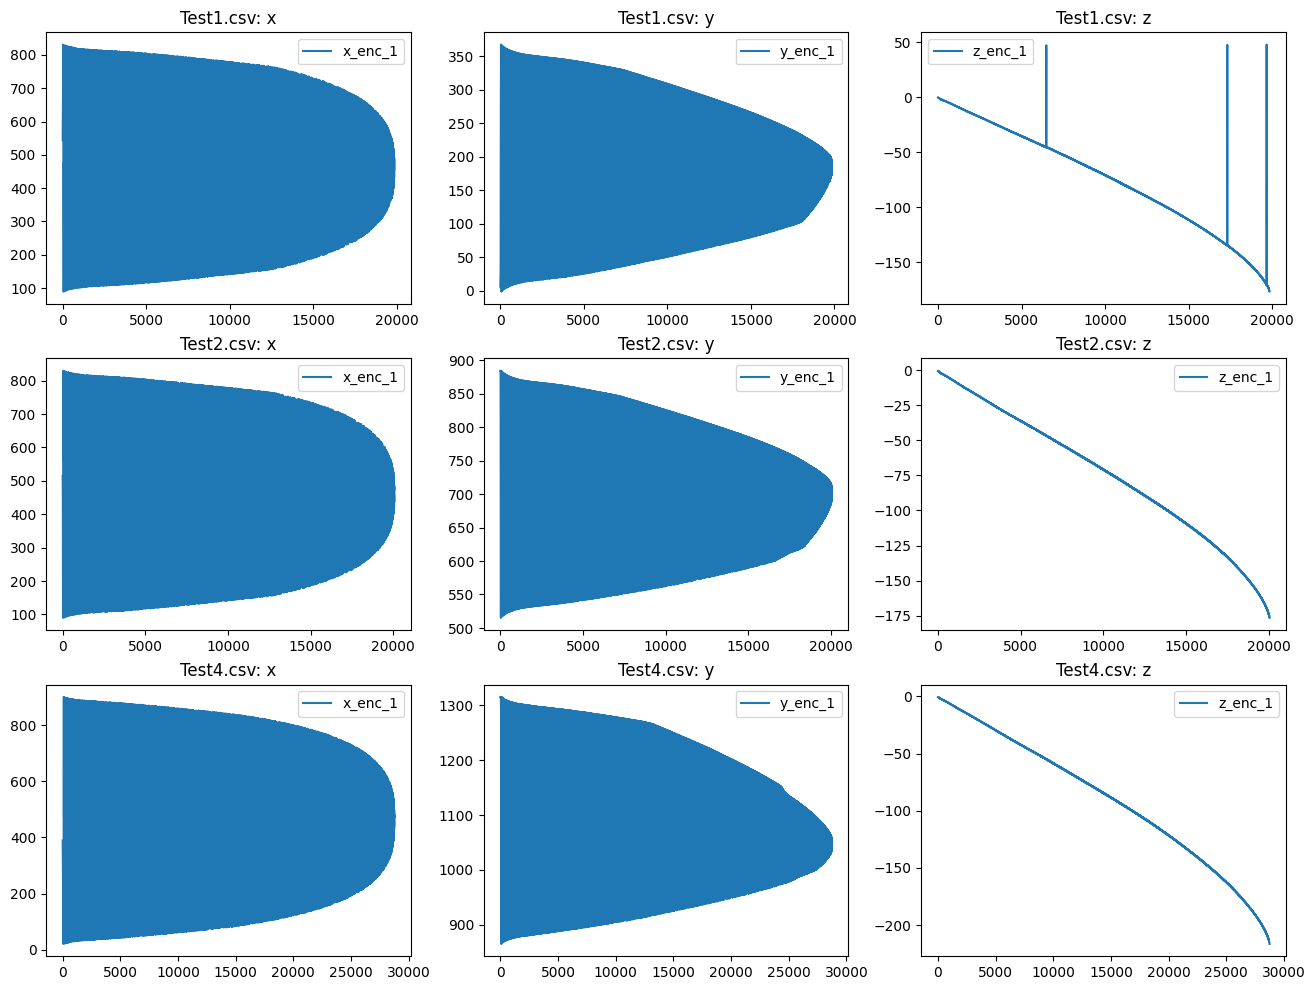

In [5]:
# What does the position trace look like over the whole run?
plot_matrix_summary(keys = ['x', 'y', 'z'], key_template = '{}_enc_1')

# At a high level, the story seems straightforward and the data appears to be pretty clean.
# The arm scans forward in z, slowly, while tracing out an outline in x/y. 
# There are 4 instances where the arm backs off in `z`, smoothly, then re-engages. 
# These show up in the force trace (but you need to zoom in to see it; see below)

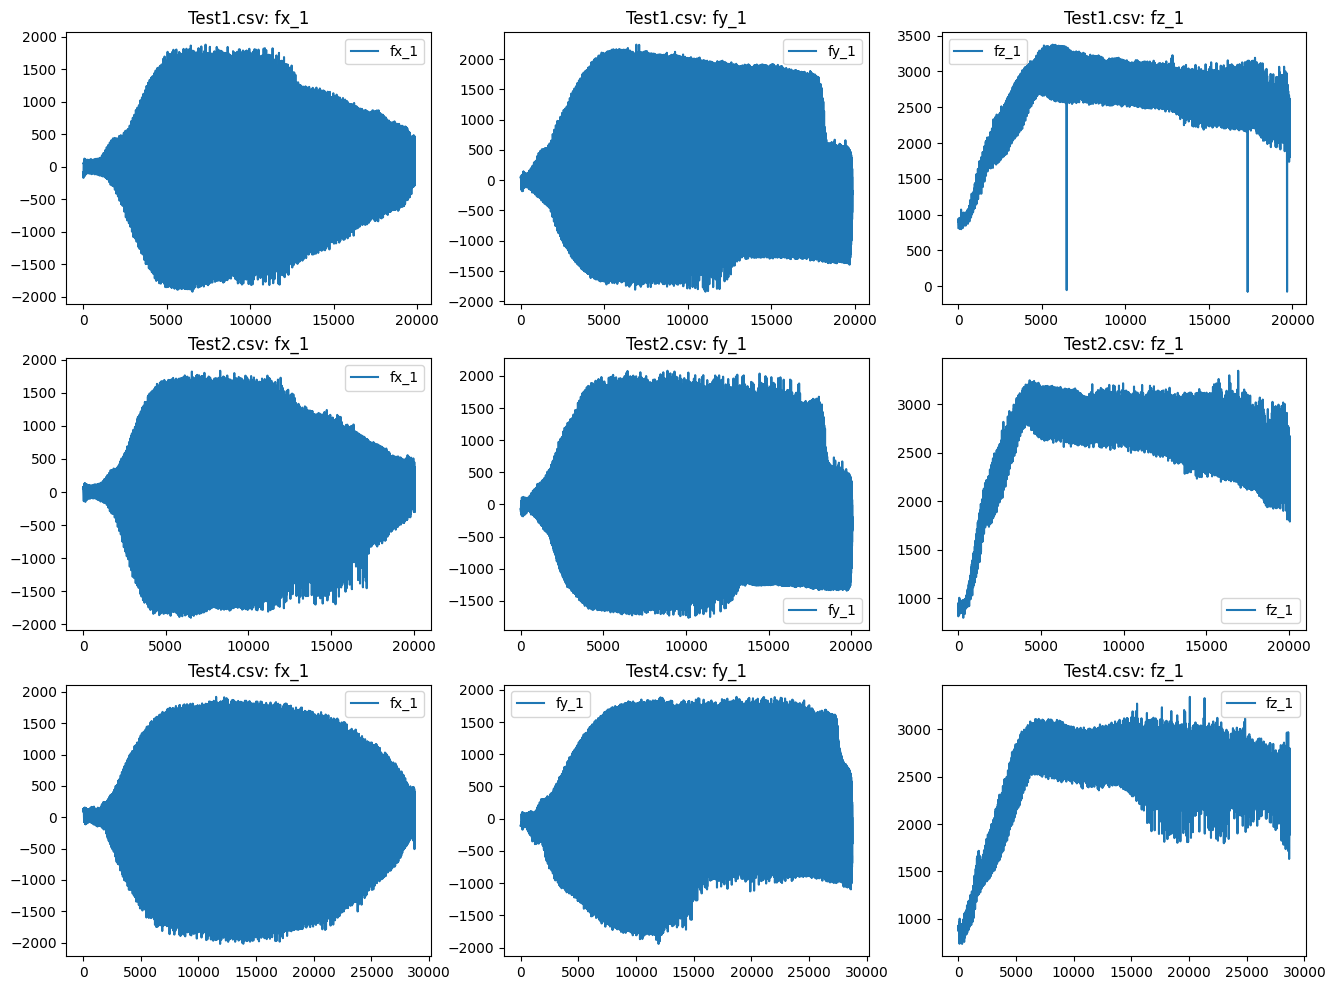

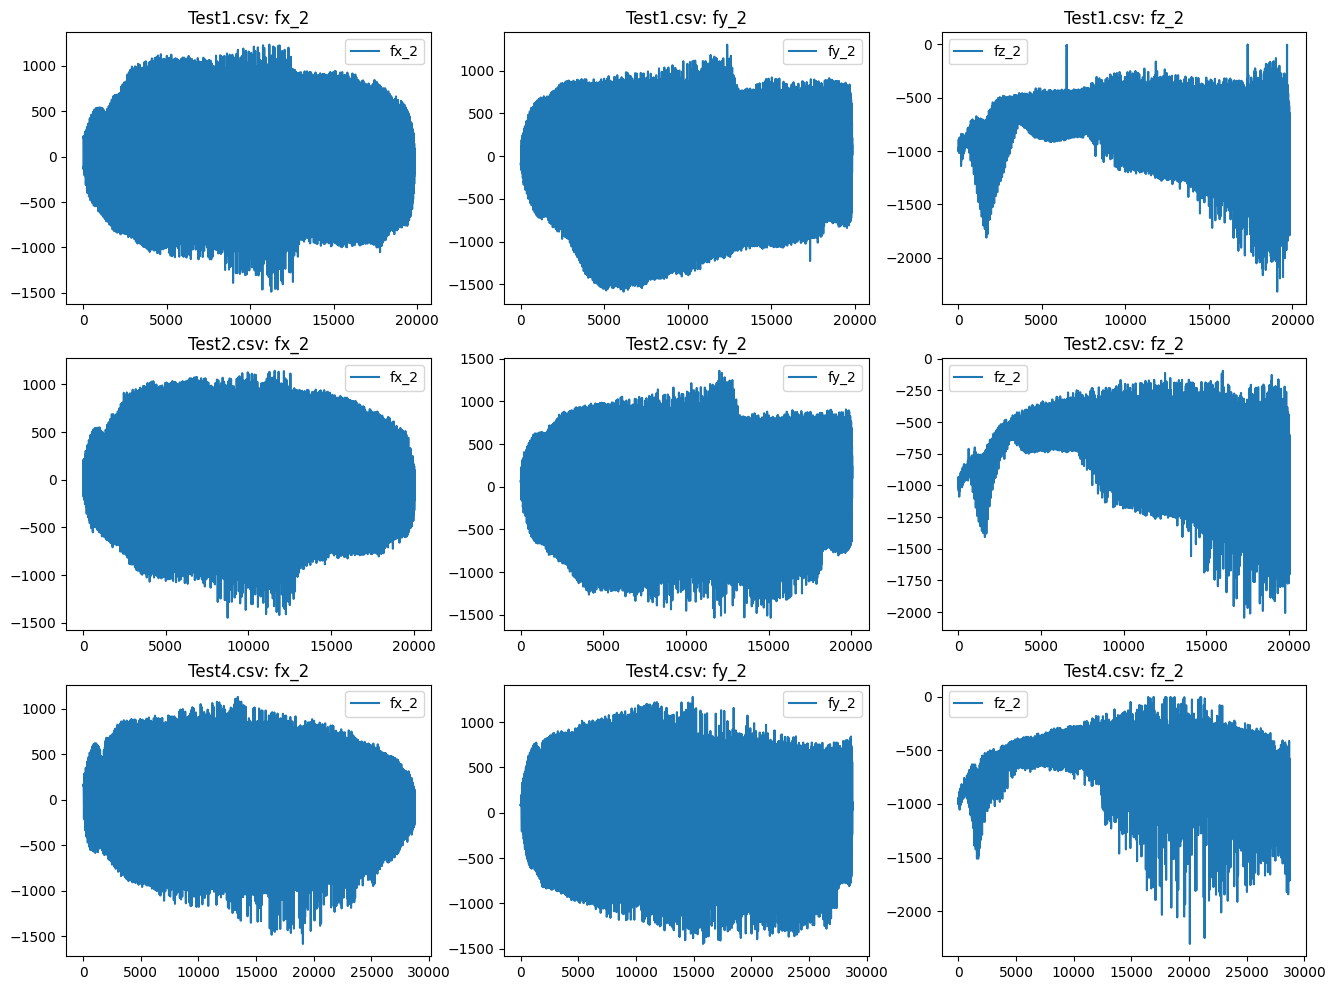

In [6]:
# Check out the forces, again, zoomed out.
plot_matrix_summary(keys = ['fx_1', 'fy_1', 'fz_1'])
plot_matrix_summary(keys = ['fx_2', 'fy_2', 'fz_2'])

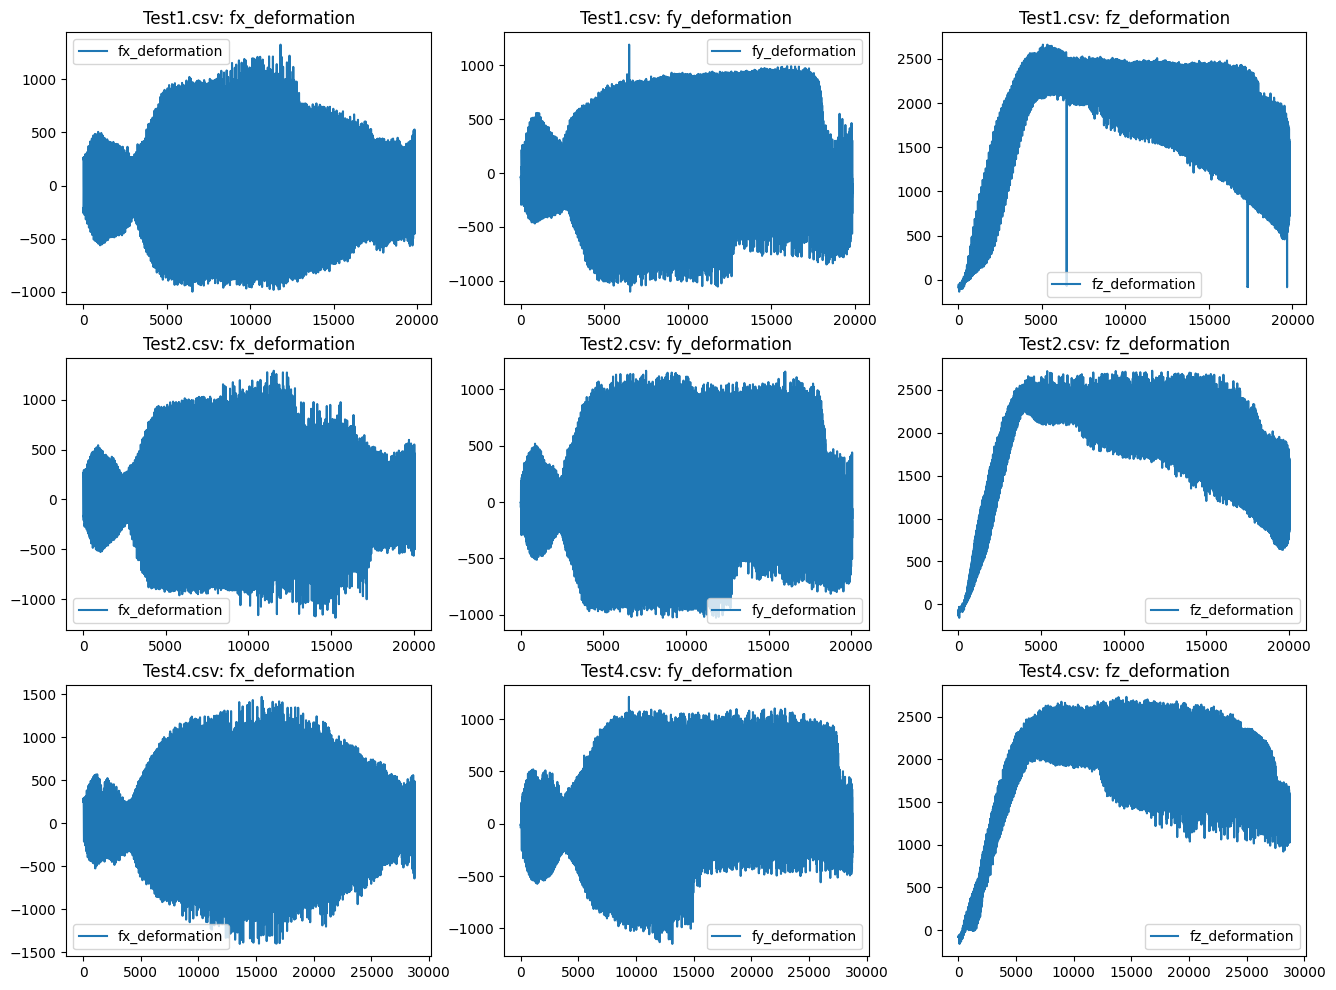

In [7]:
# Plot the overall force vector magnitudes over time to see if there are any macro trends there.
plot_matrix_summary(keys = ["fx_deformation", "fy_deformation", "fz_deformation"])

# Zoom in for high frequency noise / signal structure

We can take a look at the signal closer to the measurement resolution (Hz?) around one of the presumed pull-back events. Honestly, it looks very smooth and the signal appears to be clean.

At this point, I don't see much need for data cleaning - with the exception of finding the start/stop points and potentially filtering out the z-axis pull backs.

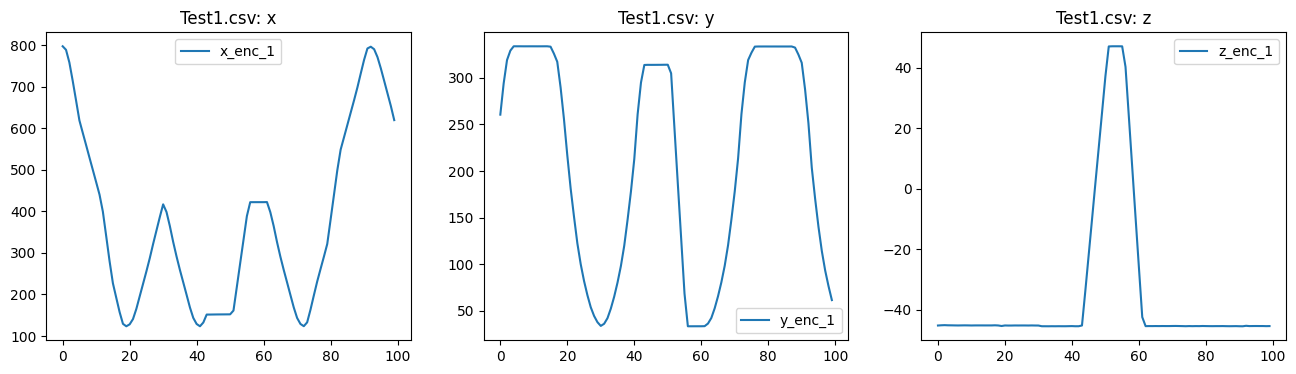

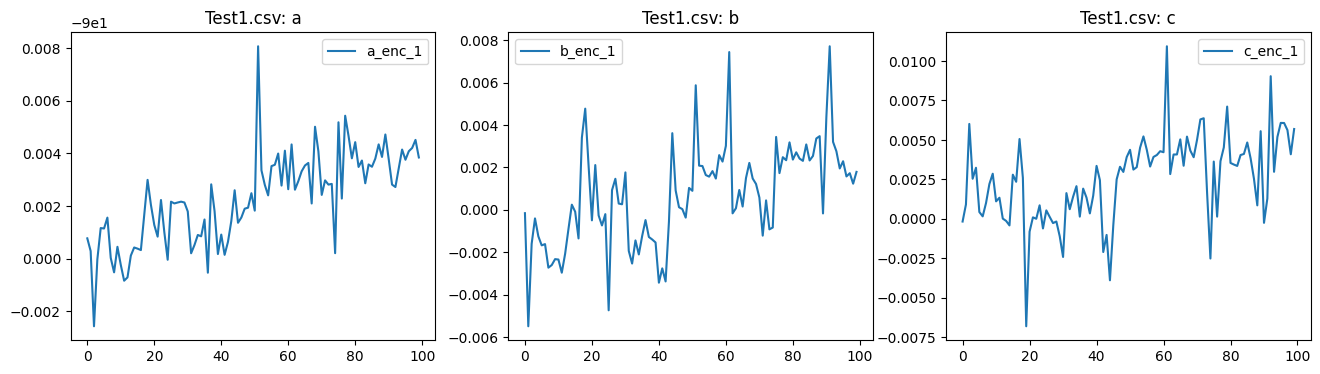

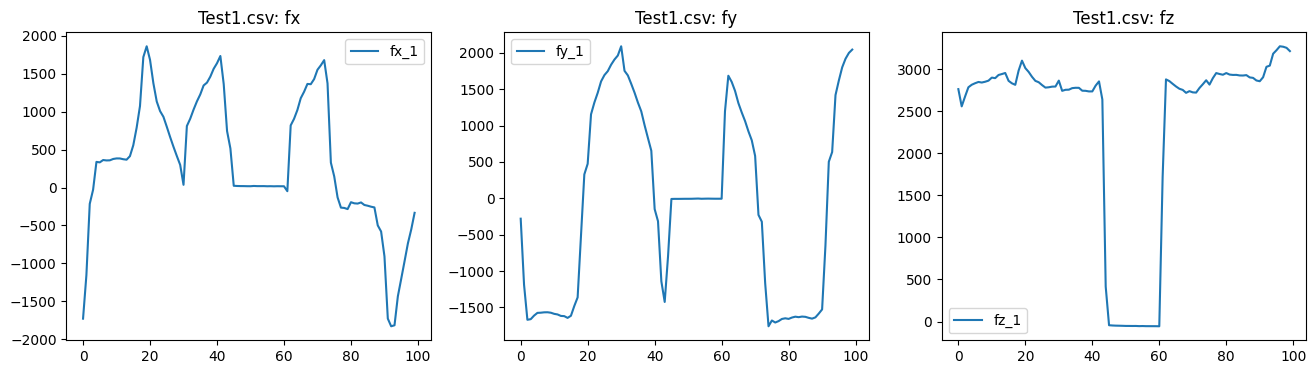

In [8]:
slc = slice(6430, 6530)

# Zoom in to the first time there is a z-axis pull-back just to see how smooth it is, if it looks like an error, etc.
plot_matrix_summary(keys = ['x', 'y', 'z'], key_template = '{}_enc_1', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['a', 'b', 'c'], key_template = '{}_enc_1', zoom_slice=slc, files=['Test1.csv'])
plot_matrix_summary(keys = ['fx', 'fy', 'fz'], key_template = '{}_1', zoom_slice=slc, files=['Test1.csv'])

# Take a look at the intermediate / meso-scale

Finally, the meso-scale story also looks pretty reasonable and smooth. The only thing that stands out is R2's "c" (yaw?). I don't see it obviously in the video, so this is a bit of an unexplained phenomenon to me right now. The frequency of the flips is higher than the force signals, though, so it doesn't seem obviously relevant. Bookmarked for later. 

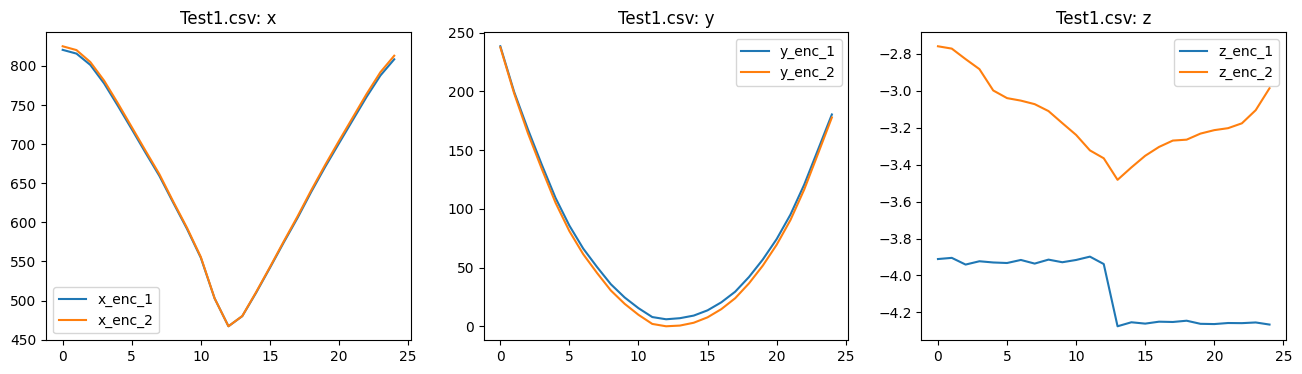

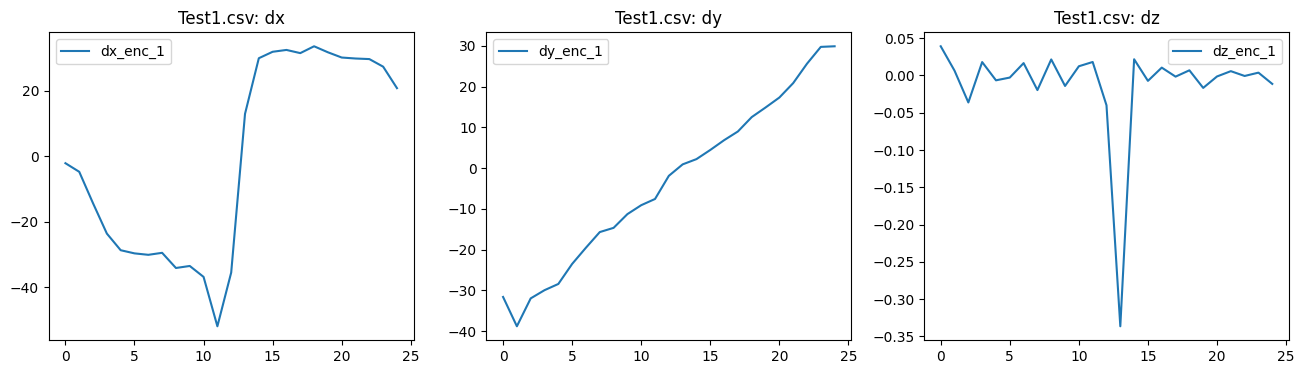

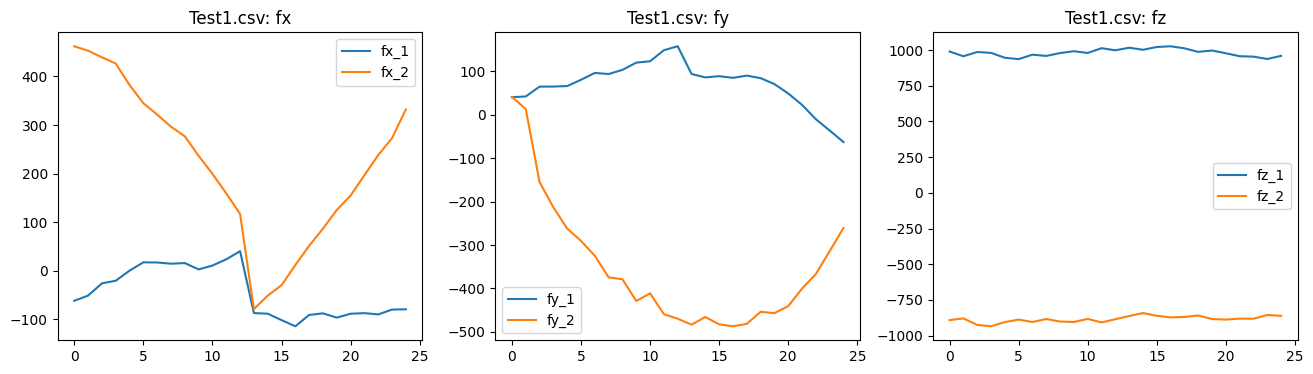

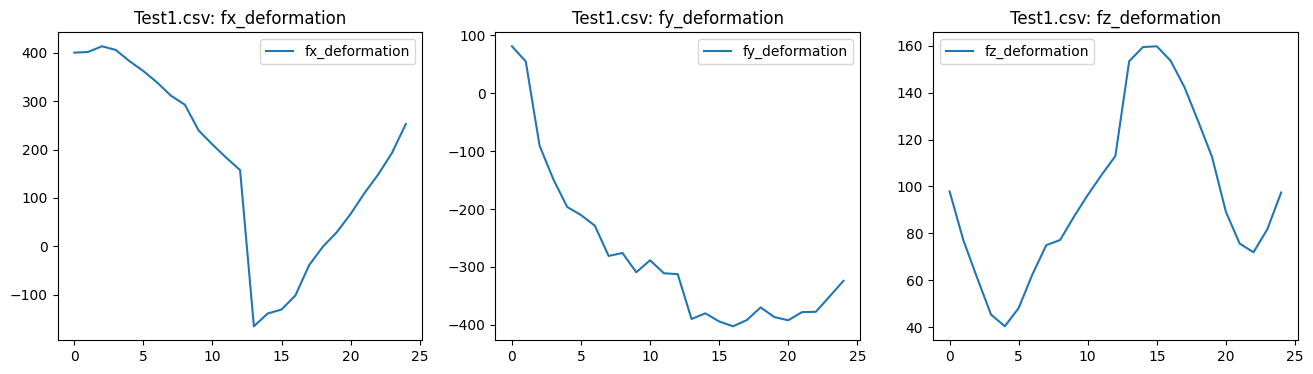

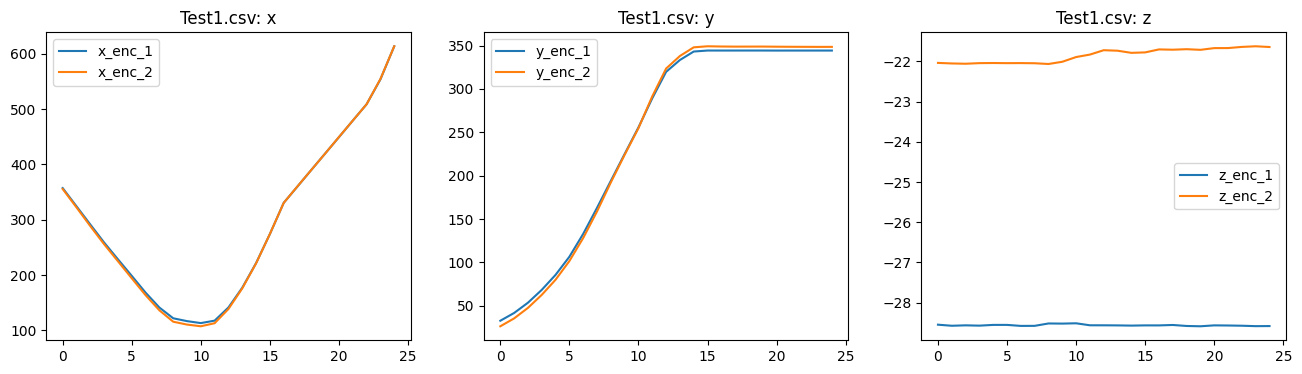

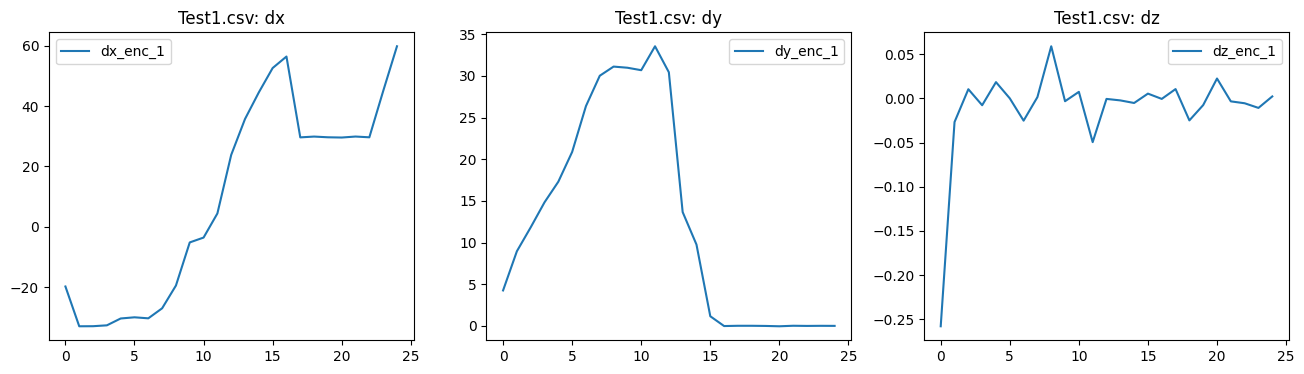

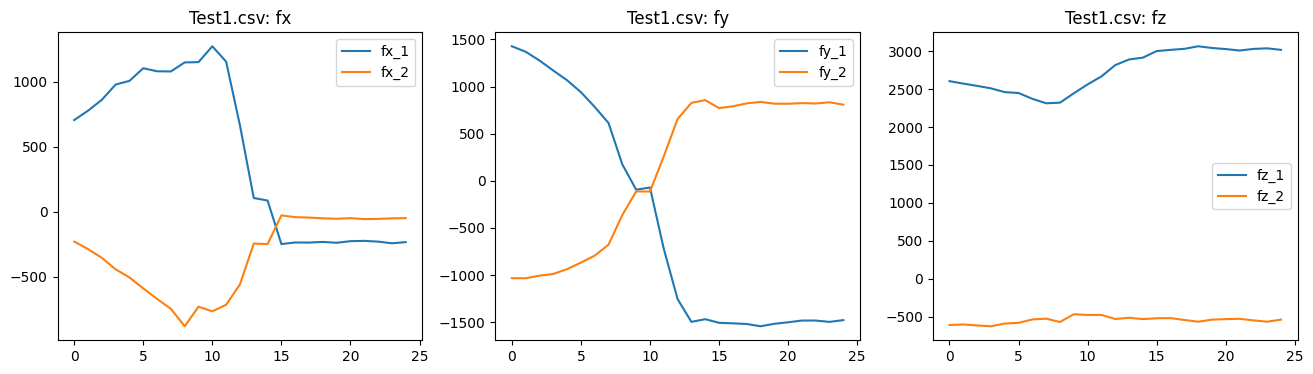

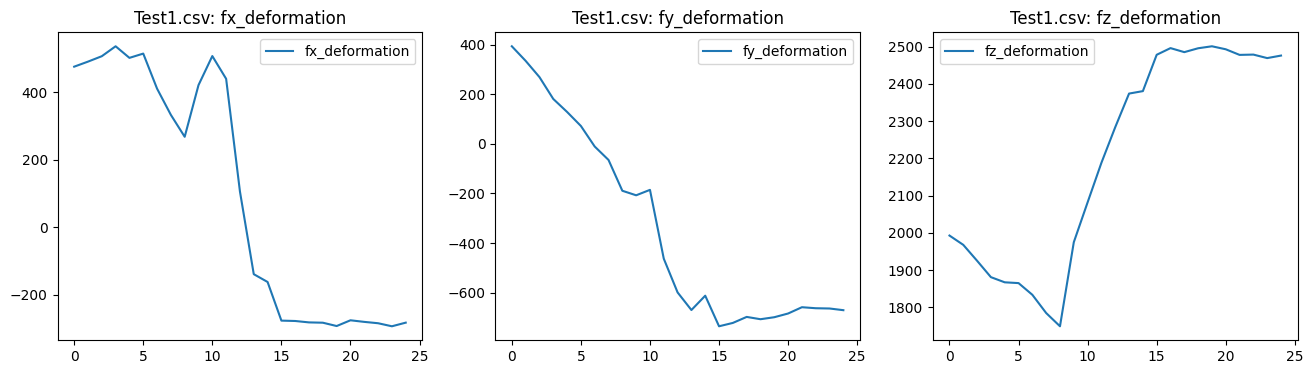

In [9]:
dt = 25

for t0 in [500, 4000]:
    slc = slice(t0, t0 + dt)

    plot_matrix_summary(keys = ['x', 'y', 'z'], subkeys = [1, 2], key_template = '{}_enc_{}', zoom_slice=slc, files=['Test1.csv'])    
    plot_matrix_summary(keys = ['dx', 'dy', 'dz'], key_template = '{}_enc_1', zoom_slice=slc, files=['Test1.csv'])
    plot_matrix_summary(keys = ['fx', 'fy', 'fz'], subkeys = [1, 2], key_template = '{}_{}', zoom_slice=slc, files=['Test1.csv'])
    plot_matrix_summary(keys = ['fx_deformation', 'fy_deformation', 'fz_deformation'], zoom_slice=slc, files=['Test1.csv'])

# Take a 3D look at the space-curves R1 and R2 trace over a few time slices

To get a sense for how forces were distributed over the surface of the part, we can just plot a 3D scatter of fx(x, y, z) (and the same with fy and fz).

In [10]:
def plot_3d_point_dynamics(slc, csv_fname, color_by, ax = None, view = [20, -120]):
    from matplotlib import cm
    import numpy as np

    if ax is None:
        py.figure()
        ax = py.subplot(projection='3d')
        
    ax.view_init(*view)
    
    for R_idx in [1]:
        # Prepare arrays x, y, z
        df = load(csv_fname)
        
        t = np.abs(df[color_by].to_numpy())[slc]      
        t = 1.0 * t - t.min()
        t = t / t.max()
        
        x = df["x_enc_{}".format(R_idx)].to_numpy()[slc]
        y = df["y_enc_{}".format(R_idx)].to_numpy()[slc]
        z = df["z_enc_{}".format(R_idx)].to_numpy()[slc]
        
        # ax.plot(x, y, z, label=color_by)
        ax.scatter(x, y, z, color=cm.hot(t), s = 10, label=color_by, alpha=0.25)
        ax.legend()
        
        ax.set_zlim(-250, 0)

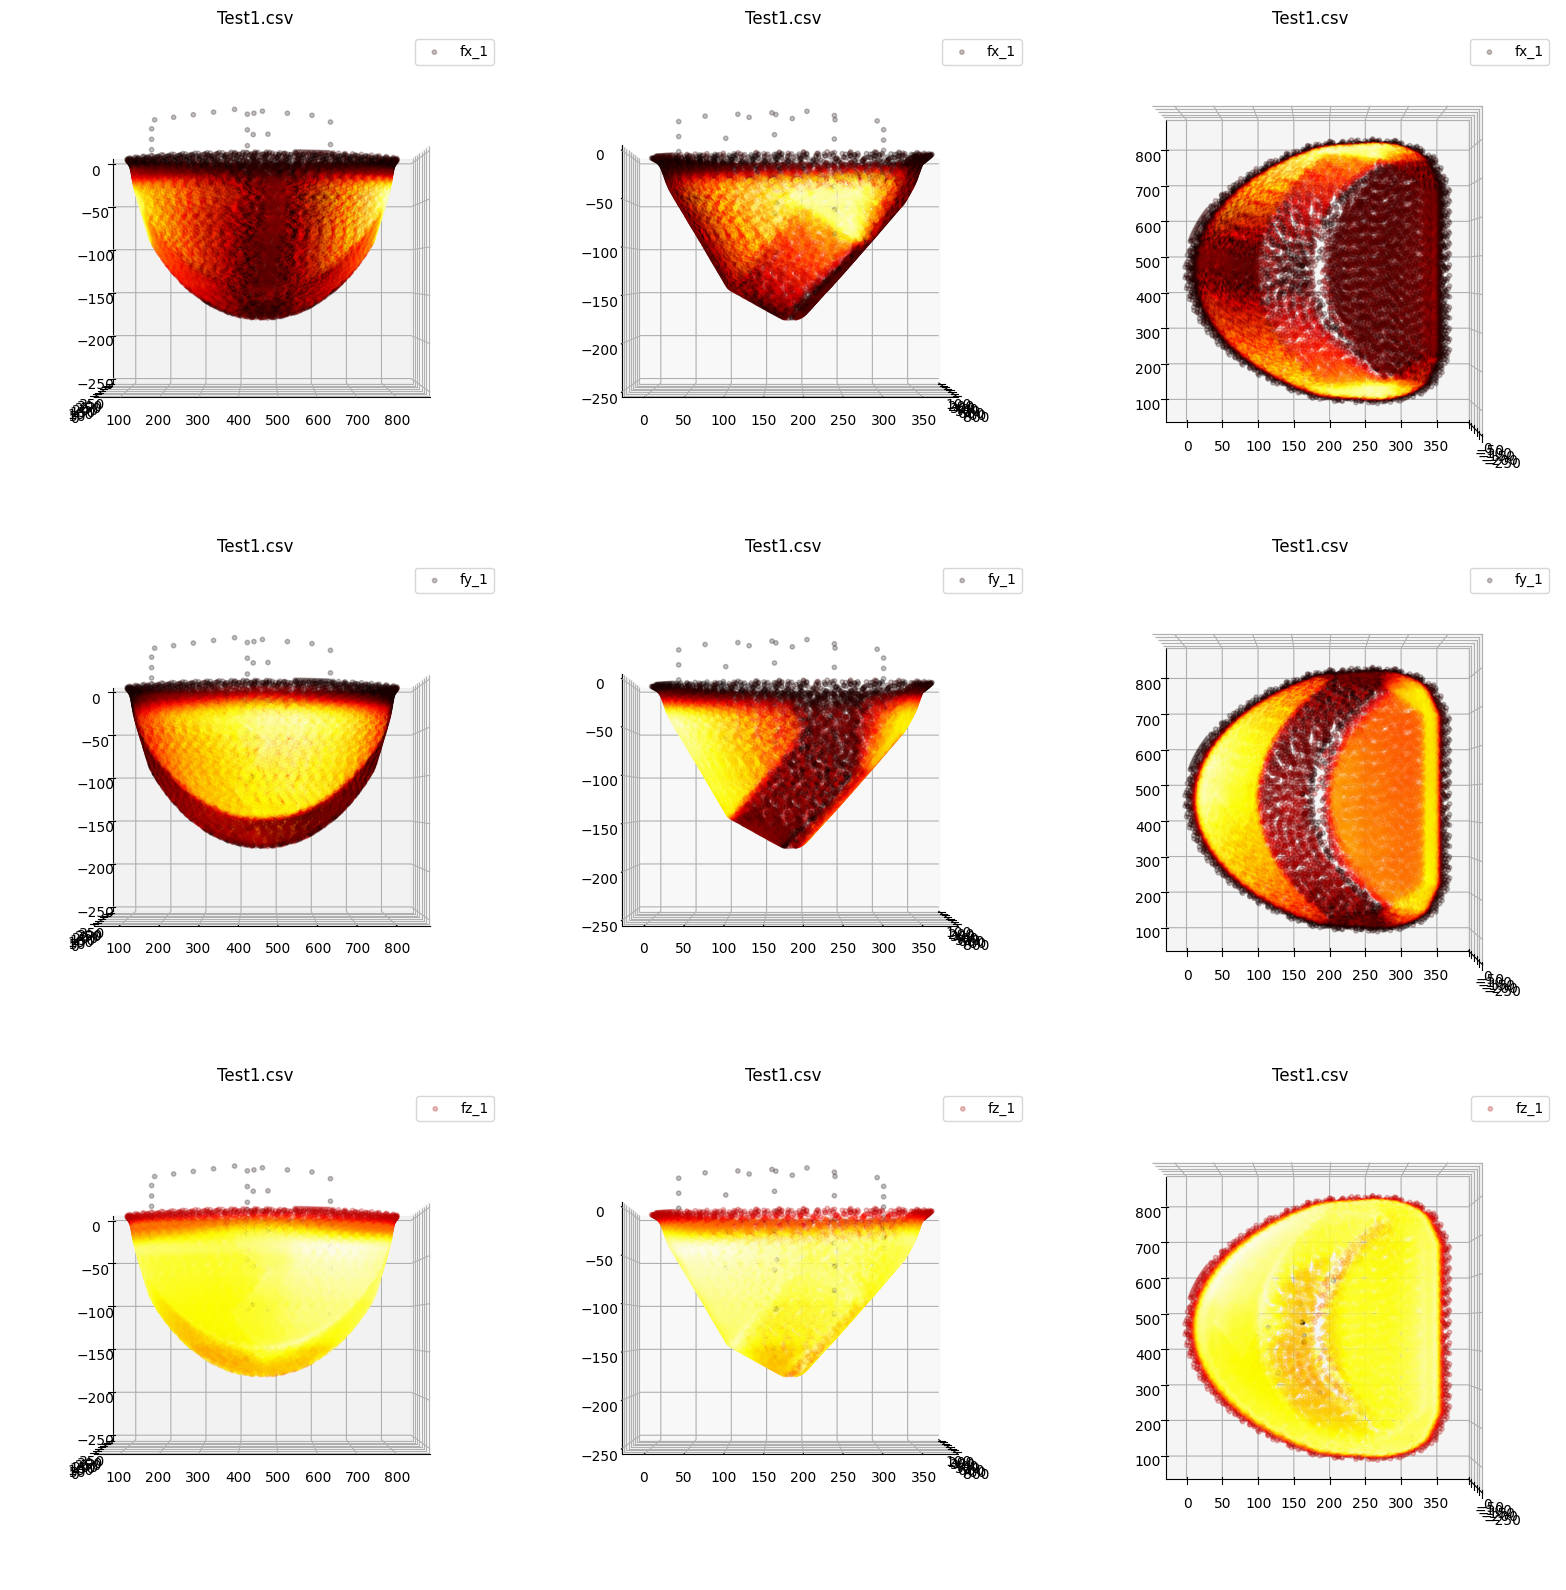

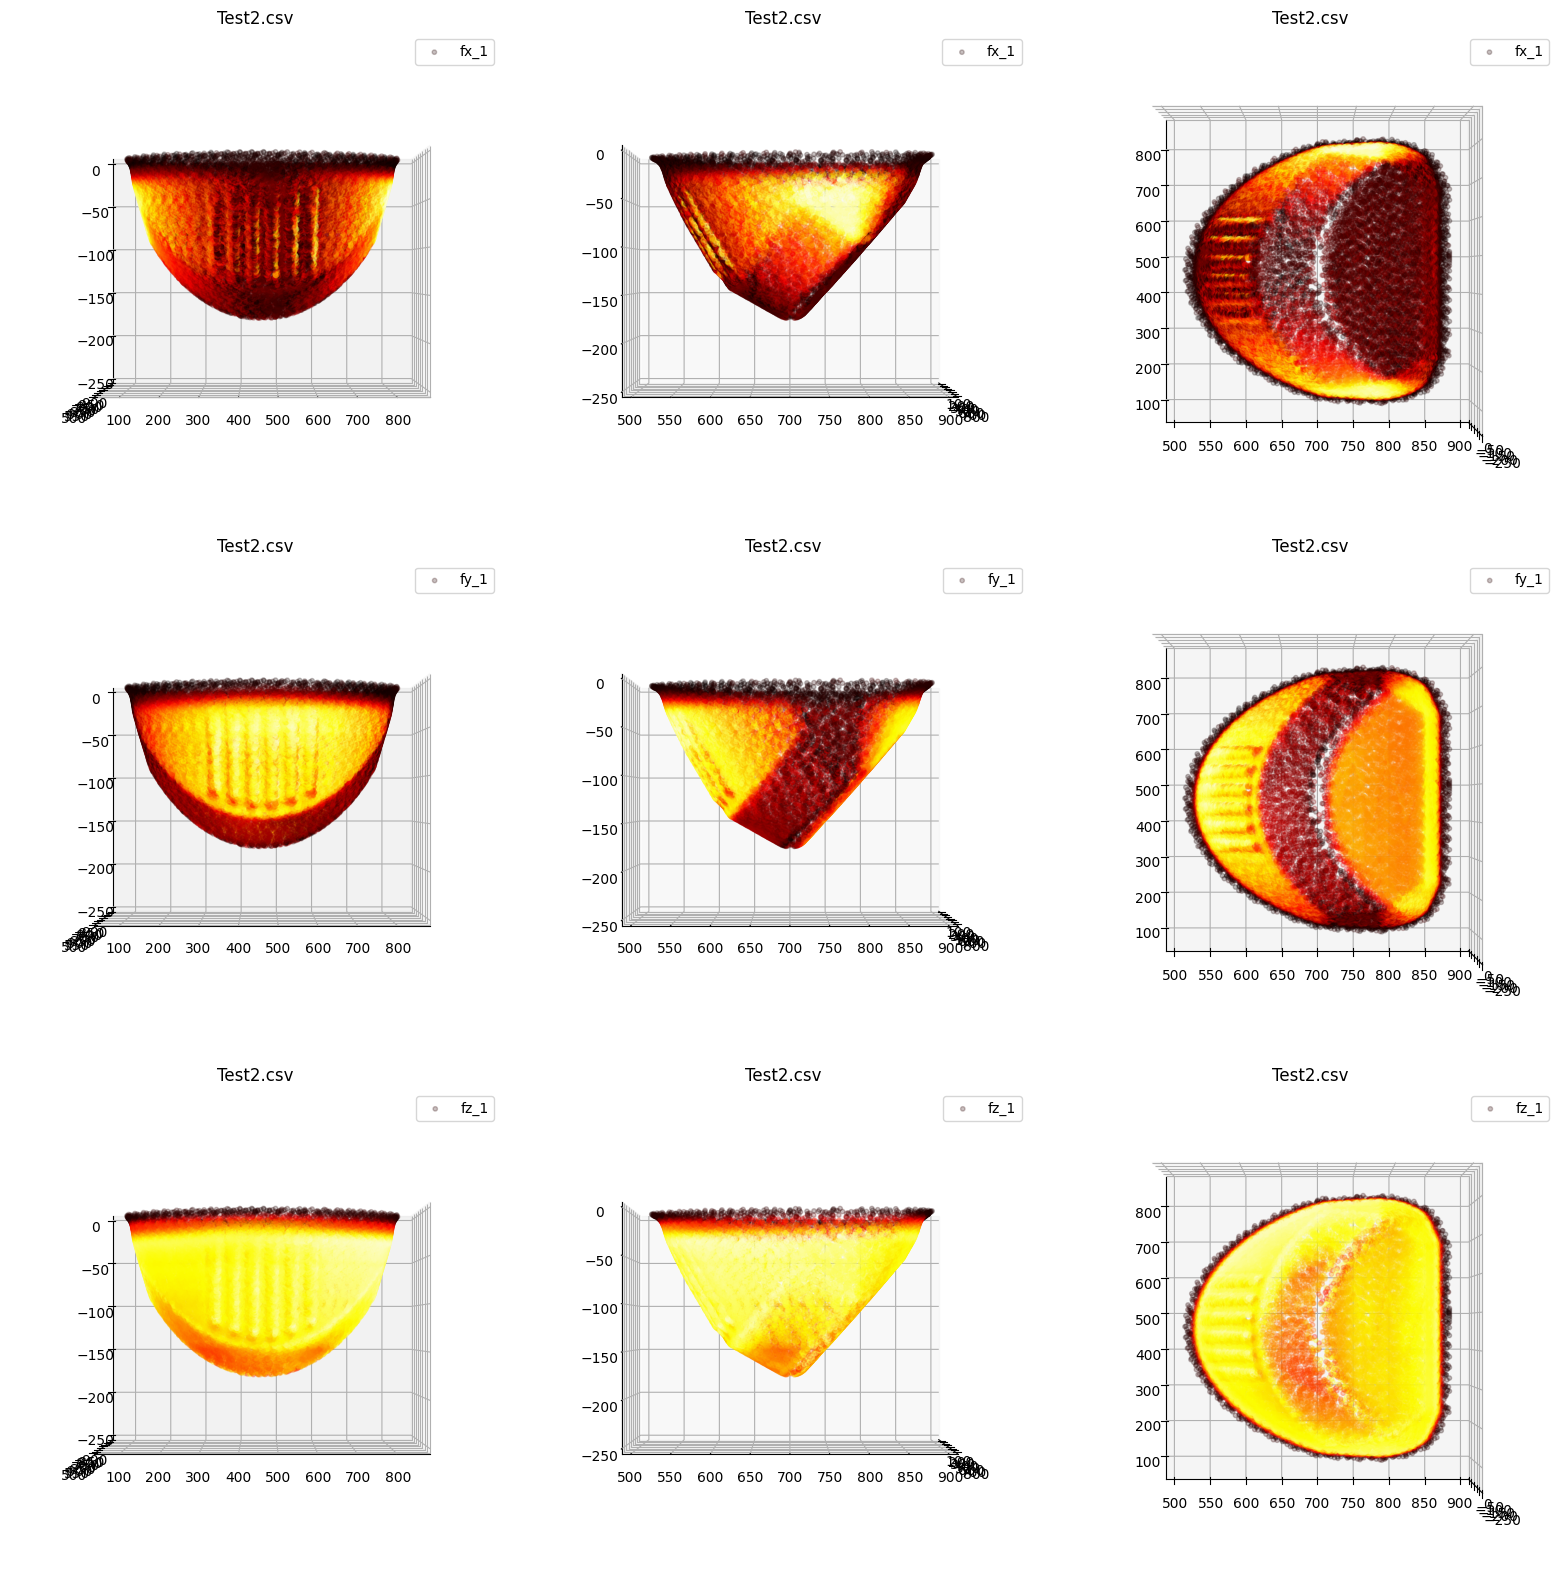

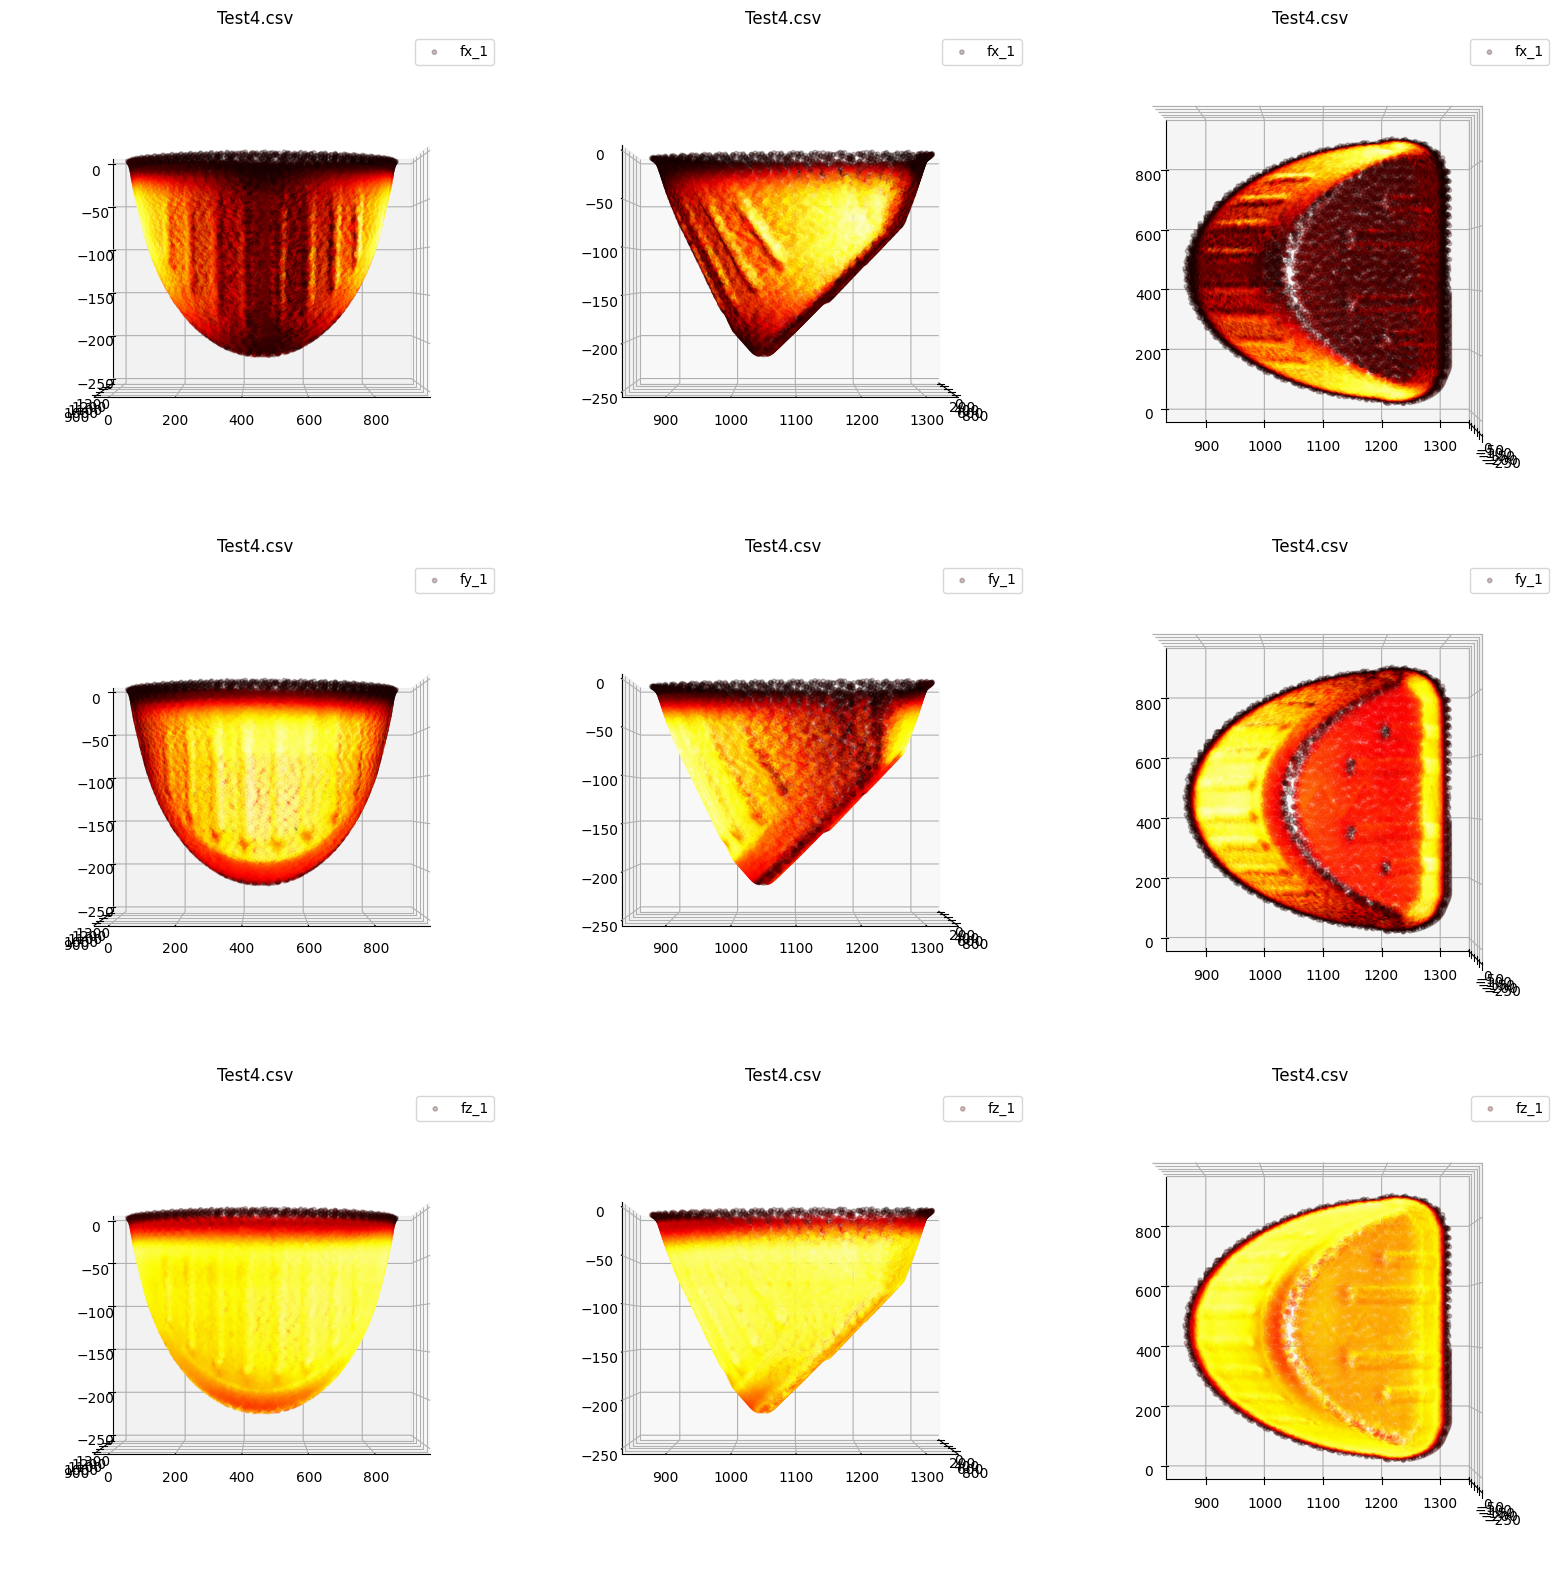

In [11]:
# Render each part as a 3D scatterplot. 
# There are 3 3x3 grids, one for each input file. Columns are 3 different views of the same part 
# and same force (1 row per force fx/fy/fz).

slc = slice(0, -1)
view = [-10, -25]

for csv in ['Test1.csv', 'Test2.csv', 'Test4.csv']:
    idx = 1
    fig = py.figure(figsize=(16, 16))
    for color_by in ["fx_1", "fy_1", "fz_1"]:
        for view in [
            [0, -90],
            [0, 0],
            [-90, 0]]:

            ax = fig.add_subplot(3, 3, idx, projection='3d')
            plot_3d_point_dynamics(slc, csv, ax = ax, color_by=color_by, view=view)
            py.title(csv)

            idx += 1

    fig.tight_layout()

# Overall summary

In terms of data quality, the curves all look fairly clean - not a lot of cleaning to be done. From a modeling perspective, though, this is a hard problem! The force distribution over the part makes intuitive sense when viewing the finished piece, but it is clearly a nontrivial map.

Moreover, the signal that determines the local force (presumably, existing local plastic strain and local intended deformation) is fairly latent in the (x,y,z) trace data. It seems unlikely we can capture fx(t, x, y, z) without somehow maintaining state about the part from time t0 -> t, but let's try it (see: First pass modeling). 

Without tracking the local deformations, the model will give erroneous predictions when running over the same positions multiple times. Out of curiosity, it would be interesting to see if simply counting the x/y positions covered by the tool is a useful surrogate feature for local deformation. 

(28747,)


<Figure size 640x480 with 0 Axes>

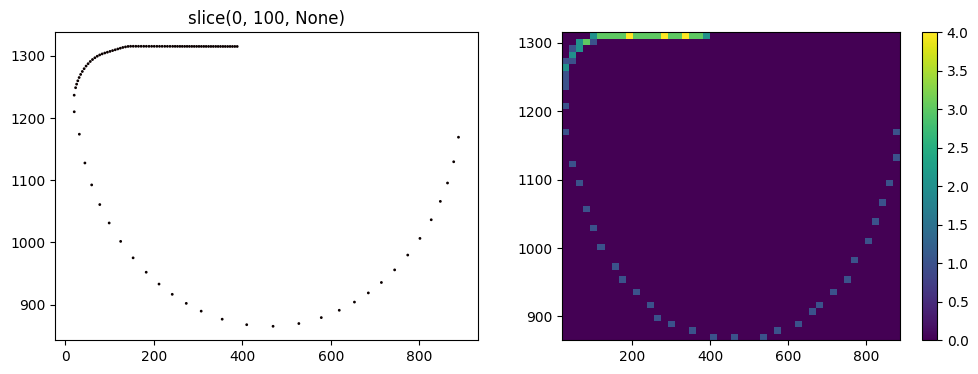

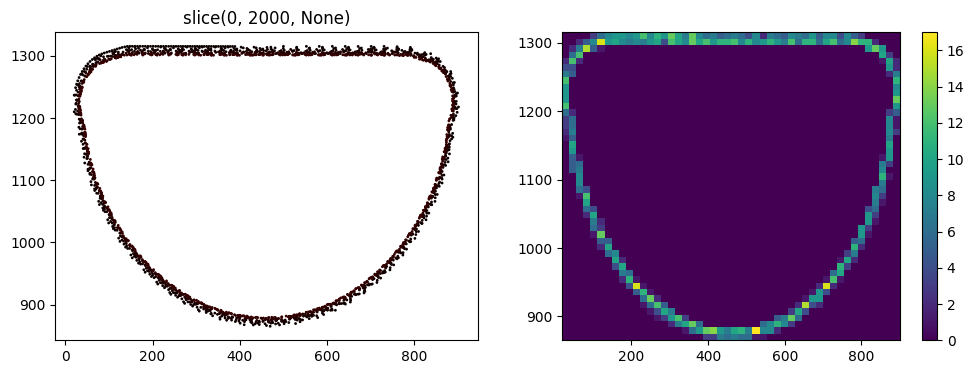

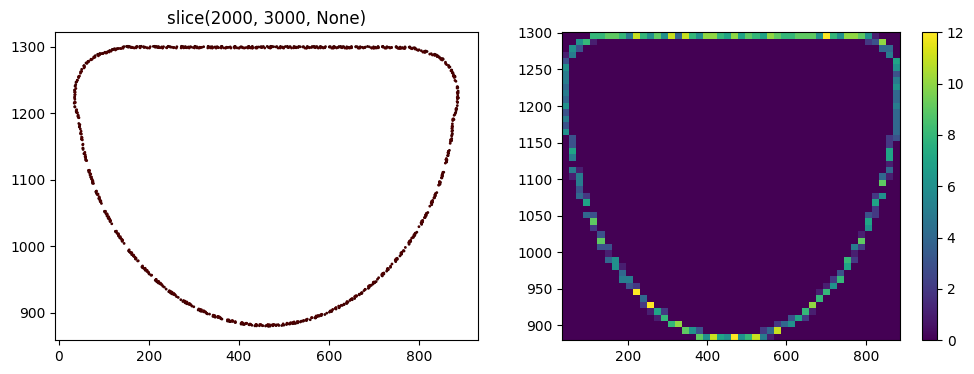

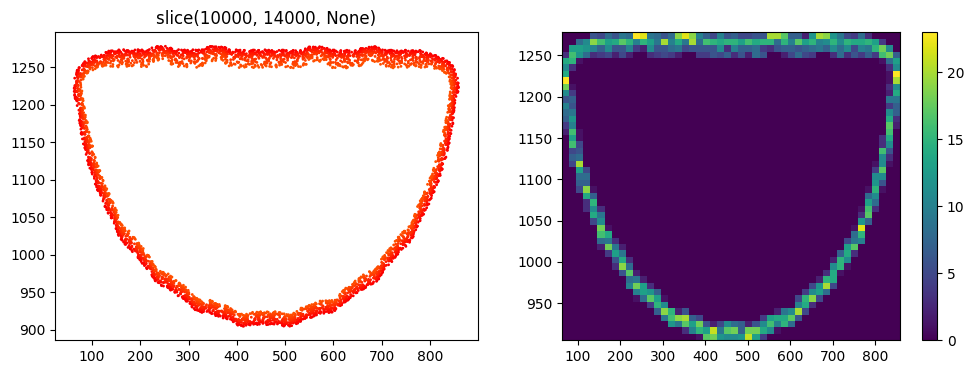

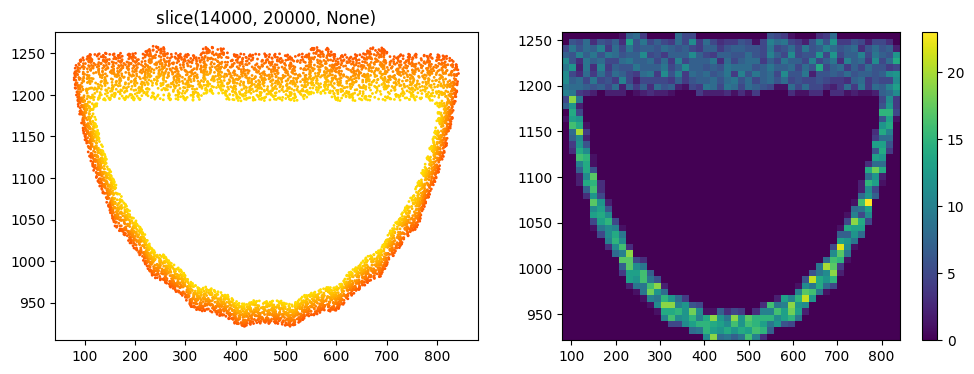

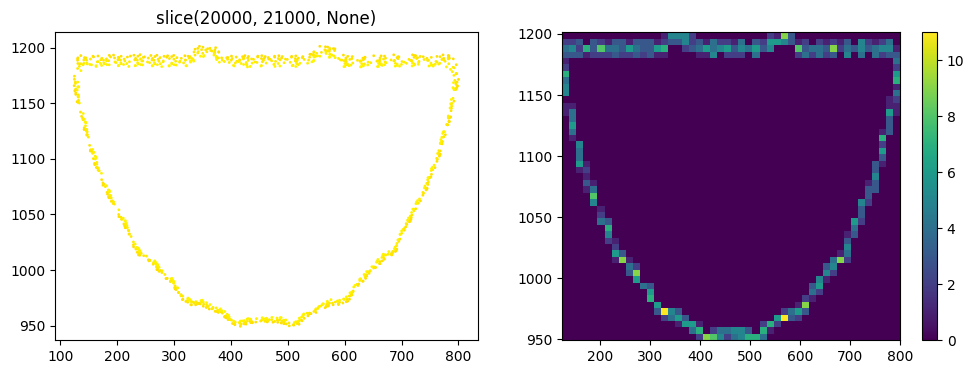

In [13]:
from matplotlib import cm

py.figure()

df = load("Test4.csv")
t = df["t"].to_numpy()
t = 1.0 * t - t[0]
t = t / t.max()

print(t.shape)

slc = slice(0, 100)
nbins = 48
for slc in [slice(0, 100), slice(0, 2000), slice(2000, 3000), slice(10000, 14000), slice(14000, 20000), slice(20000, 21000)]:    
    py.figure(figsize=(12, 4))
    py.subplot(1, 2, 1)
    
    py.title(str(slc))
#     py.xlim(50, 850)
#     py.ylim(-10, 380)
    py.scatter(df['x_enc_1'].to_numpy()[slc], df['y_enc_1'].to_numpy()[slc], color=cm.hot(t[slc]), s=1, marker='o')

    py.subplot(1, 2, 2)
    py.hist2d(df['x_enc_1'].to_numpy()[slc], df['y_enc_1'].to_numpy()[slc], bins=nbins)
    py.colorbar()